In [106]:
# import libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.calibration import CalibrationDisplay, CalibratedClassifierCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.metrics import multilabel_confusion_matrix, plot_confusion_matrix, f1_score, brier_score_loss, accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler

## Preprocessing

In [4]:
# load in data with relative path
tree_df = pd.read_csv('2015_Street_Tree_Census_-_Tree_Data.csv')

In [5]:
# drop columns
tree_df = tree_df.drop(columns=[
    'borocode', 'x_sp', 'y_sp', 'state', 'nta_name', 'zip_city', 'address',
    'spc_latin', 'created_at', 'tree_id', 'block_id', 'user_type', 'bin',
    'bbl', 'council district', 'boro_ct', 'census tract', 'problems', 'status',
    'stump_diam', 'postcode', 'community board', 'cncldist', 'st_assem', 'st_senate', 
    'nta', 'spc_common'
])

# drop NA and dead tree values
tree_df = tree_df[tree_df['health'].notna()]
tree_df = tree_df.dropna(how='any')

In [6]:
# scale diameters 
scaler = StandardScaler()
tree_df['tree_dbh'] = scaler.fit_transform(tree_df[['tree_dbh']])

# Ordinal Encode
health = ['Poor', 'Fair', 'Good']
enc = OrdinalEncoder(categories=[health])
tree_df['health'] = enc.fit_transform(tree_df[['health']])

steward = ['None', '1or2', '3or4', '4orMore']
enc = OrdinalEncoder(categories=[steward])
tree_df['steward'] = enc.fit_transform(tree_df[['steward']])

sidewalk = ['NoDamage', 'Damage']
enc = OrdinalEncoder(categories=[sidewalk])
tree_df['sidewalk'] = enc.fit_transform(tree_df[['sidewalk']])

curbloc = ['OnCurb', 'OffsetFromCurb']
enc = OrdinalEncoder(categories=[curbloc])
tree_df['curb_loc'] = enc.fit_transform(tree_df[['curb_loc']])

yes_no = ['No', 'Yes']
enc = OrdinalEncoder(categories=[yes_no])

yes_no_features = [
    'brch_other', 'brch_shoe', 'brch_light', 'trnk_other', 'trnk_light',
    'trunk_wire', 'root_other', 'root_grate', 'root_stone'
]

for feat in yes_no_features:
    tree_df[feat] = enc.fit_transform(tree_df[[feat]])
    
# One Hot Encode
enc = OneHotEncoder()
guards = enc.fit_transform(tree_df[['guards']])
tree_df['guards_' + enc.categories_[0][:]] = guards.toarray()
tree_df = tree_df.drop(columns=['guards'])

guards = enc.fit_transform(tree_df[['borough']])
tree_df['borough_' + enc.categories_[0][:]] = guards.toarray()
tree_df = tree_df.drop(columns=['borough'])

In [7]:
# split to x and y sets
y = np.asarray(tree_df['health'])
x = tree_df.drop(columns=['health'])

In [8]:
# random sample (stratified) for dev, test, train and val
x_dev, x_test, y_dev, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify = y)
x_train, x_val, y_train, y_val = train_test_split(x_dev, y_dev, test_size=0.2, random_state=42, stratify = y_dev)

In [16]:
x_dev.shape, y_dev.shape, x_test.shape

((521736, 24), (521736,), (130434, 24))

In [9]:
# over-sampling of training data
ros = RandomOverSampler(random_state=42)
x_ros, y_ros = ros.fit_resample(x_train, y_train)

In [10]:
# under sampling of training data
rus = RandomUnderSampler(random_state=42)
x_rus, y_rus = rus.fit_resample(x_train, y_train)

In [17]:
x_rus.shape

(51489, 24)

In [11]:
# smote sampling of training data
smote = SMOTE(random_state=42)
x_smote, y_smote = smote.fit_resample(x_train, y_train)

## Random Forest Training

In [149]:
# Test non-sampled data
rfc_non_sample = RandomForestClassifier()
rfc_non_sample.fit(x_train, y_train)
rfc_non_sample_score = rfc_non_sample.score(x_test, y_test)
print(rfc_non_sample_score)

0.8087001855344466


In [135]:
# Testing dropping longitude and latitude
rfc_no_lat_lon = RandomForestClassifier()
rfc_no_lat_lon.fit(x_ros.drop(columns=['latitude', 'longitude']), y_ros)
rfc_no_lat_lon_score = rfc_no_lat_lon.score(x_test.drop(columns=['latitude', 'longitude']), y_test)
print(rfc_no_lat_lon_score)

0.5197264516920435


In [132]:
max([estimator.tree_.max_depth for estimator in rfc_no_lat_lon.estimators_])

37

In [12]:
rfc_over_def = RandomForestClassifier()
rfc_over_def.fit(x_ros, y_ros)
rfc_over_def_score = rfc_over_def.score(x_test, y_test)
print("RFC score (default params, oversampling):", rfc_over_def_score)

RFC score (default params, oversampling): 0.7781330021313462


In [75]:
max([estimator.tree_.max_depth for estimator in rfc_over_def.estimators_])

68

In [13]:
rfc_under_def = RandomForestClassifier()
rfc_under_def.fit(x_rus, y_rus)
rfc_under_def_score = rfc_under_def.score(x_test, y_test)
print("RFC score (default params, undersampling):", rfc_under_def_score)

RFC score (default params, undersampling): 0.4834705674900716


In [123]:
max([estimator.tree_.max_depth for estimator in rfc_under_def.estimators_])

57

In [14]:
rfc_smote_def = RandomForestClassifier()
rfc_smote_def.fit(x_smote, y_smote)
rfc_smote_def_score = rfc_smote_def.score(x_test, y_test)
print("RFC score (default params, SMOTE):", rfc_smote_def_score)

RFC score (default params, undersampling): 0.6614226352024779


In [124]:
max([estimator.tree_.max_depth for estimator in rfc_smote_def.estimators_])

68

### Hyper-parameter tuning

In [99]:
params = {
    'max_depth': np.linspace(1, 68, 68, dtype=int),
    'n_estimators': np.linspace(20, 100, 81, dtype=int)
}

In [102]:
def hyperparams_rfc(scoring_method, params, x, y):
    rfc = RandomForestClassifier()
    cv = RandomizedSearchCV(rfc, params, n_jobs=8, scoring=scoring_method, verbose=2)
    cv.fit(x, y)
    return cv.best_params_

In [103]:
accuracy_over_params = hyperparams_rfc('accuracy', params, x_ros, y_ros)
f1_over_params = hyperparams_rfc('f1_macro', params, x_ros, y_ros)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END ......................max_depth=10, n_estimators=36; total time=  16.5s
[CV] END ......................max_depth=46, n_estimators=74; total time=11.5min


/Users/talzuss/anaconda3/envs/aml/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END ......................max_depth=16, n_estimators=70; total time=  43.4s
[CV] END ......................max_depth=20, n_estimators=21; total time=  14.2s
[CV] END ......................max_depth=20, n_estimators=21; total time=  14.9s
[CV] END ......................max_depth=21, n_estimators=25; total time=11.0min
[CV] END ......................max_depth=10, n_estimators=36; total time=  16.1s
[CV] END ......................max_depth=10, n_estimators=36; total time=  15.4s
[CV] END ......................max_depth=46, n_estimators=74; total time=13.0min
[CV] END ......................max_depth=10, n_estimators=36; total time=  16.4s
[CV] END ......................max_depth=10, n_estimators=36; total time=  16.2s
[CV] END ......................max_depth=46, n_estimators=74; total time=12.9min
[CV] END ......................max_depth=16, n_estimators=70; total time=  43.2s
[CV] END ......................max_depth=46, n_estimators=74; total time=12.9min
[CV] END ...................

/Users/talzuss/anaconda3/envs/aml/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END ......................max_depth=11, n_estimators=84; total time=  41.1s
[CV] END ......................max_depth=62, n_estimators=44; total time=  40.3s
[CV] END ......................max_depth=28, n_estimators=37; total time=  33.2s
[CV] END ......................max_depth=52, n_estimators=43; total time=  42.2s
[CV] END ......................max_depth=36, n_estimators=81; total time= 1.3min
[CV] END ......................max_depth=52, n_estimators=43; total time=  42.6s
[CV] END ......................max_depth=36, n_estimators=81; total time= 1.3min
[CV] END ......................max_depth=36, n_estimators=81; total time= 1.3min
[CV] END ......................max_depth=36, n_estimators=99; total time= 1.6min
[CV] END ......................max_depth=62, n_estimators=44; total time=  38.9s
[CV] END ......................max_depth=28, n_estimators=37; total time=  32.5s
[CV] END ......................max_depth=52, n_estimators=43; total time=  42.3s
[CV] END ...................

In [104]:
accuracy_under_params = hyperparams_rfc('accuracy', params, x_rus, y_rus)
f1_under_params = hyperparams_rfc('f1_macro', params, x_rus, y_rus)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END ......................max_depth=25, n_estimators=68; total time=   2.4s
[CV] END ......................max_depth=51, n_estimators=29; total time=   1.1s
[CV] END ......................max_depth=58, n_estimators=29; total time=   1.0s
[CV] END ......................max_depth=25, n_estimators=52; total time=   1.6s
[CV] END ......................max_depth=10, n_estimators=77; total time=   1.3s
[CV] END ......................max_depth=15, n_estimators=37; total time=   0.8s
[CV] END ......................max_depth=15, n_estimators=37; total time=   0.8s
[CV] END ......................max_depth=34, n_estimators=39; total time=   1.4s
[CV] END ......................max_depth=34, n_estimators=36; total time=   1.3s


/Users/talzuss/anaconda3/envs/aml/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END ......................max_depth=40, n_estimators=64; total time= 1.0min
[CV] END ......................max_depth=35, n_estimators=30; total time=  28.2s
[CV] END ......................max_depth=35, n_estimators=30; total time=  28.4s
[CV] END ......................max_depth=60, n_estimators=83; total time=   3.1s
[CV] END ......................max_depth=51, n_estimators=29; total time=   1.1s
[CV] END ......................max_depth=58, n_estimators=29; total time=   1.0s
[CV] END ......................max_depth=36, n_estimators=37; total time=   1.3s
[CV] END ......................max_depth=10, n_estimators=77; total time=   1.3s
[CV] END ......................max_depth=15, n_estimators=37; total time=   0.8s
[CV] END ......................max_depth=29, n_estimators=36; total time=   1.2s
[CV] END ......................max_depth=34, n_estimators=39; total time=   1.4s
[CV] END ......................max_depth=34, n_estimators=36; total time=   1.3s
[CV] END ...................

In [105]:
accuracy_smote_params = hyperparams_rfc('accuracy', params, x_smote, y_smote)
f1_smote_params = hyperparams_rfc('f1_macro', params, x_smote, y_smote)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END ......................max_depth=25, n_estimators=68; total time=   2.3s
[CV] END ......................max_depth=25, n_estimators=68; total time=   2.1s
[CV] END ......................max_depth=25, n_estimators=52; total time=   1.6s
[CV] END ......................max_depth=10, n_estimators=77; total time=   1.2s
[CV] END .......................max_depth=9, n_estimators=90; total time=   1.4s
[CV] END ......................max_depth=34, n_estimators=39; total time=   1.4s
[CV] END ......................max_depth=34, n_estimators=36; total time=   1.3s
[CV] END ......................max_depth=26, n_estimators=26; total time=   0.9s
[CV] END ......................max_depth=13, n_estimators=58; total time=   1.2s
[CV] END .......................max_depth=7, n_estimators=29; total time=   0.4s
[CV] END .......................max_depth=7, n_estimators=29; total time=   0.4s
[CV] END ......................max_depth=10, n_e

/Users/talzuss/anaconda3/envs/aml/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END ......................max_depth=25, n_estimators=68; total time=   2.3s
[CV] END ......................max_depth=25, n_estimators=68; total time=   2.1s
[CV] END ......................max_depth=25, n_estimators=52; total time=   1.6s
[CV] END .......................max_depth=9, n_estimators=90; total time=   1.4s
[CV] END ......................max_depth=15, n_estimators=37; total time=   0.8s
[CV] END ......................max_depth=29, n_estimators=36; total time=   1.2s
[CV] END ......................max_depth=16, n_estimators=63; total time=   1.5s
[CV] END ......................max_depth=34, n_estimators=39; total time=   1.4s
[CV] END ......................max_depth=65, n_estimators=53; total time=   1.9s
[CV] END ......................max_depth=13, n_estimators=58; total time=   1.2s
[CV] END ......................max_depth=10, n_estimators=67; total time=   1.1s
[CV] END ......................max_depth=23, n_estimators=67; total time=   2.1s
[CV] END ...................

[CV] END ......................max_depth=51, n_estimators=75; total time= 1.6min
[CV] END ......................max_depth=50, n_estimators=25; total time=  30.9s
[CV] END ......................max_depth=46, n_estimators=92; total time= 1.9min
[CV] END ......................max_depth=26, n_estimators=50; total time=  49.4s
[CV] END ......................max_depth=51, n_estimators=75; total time= 1.6min
[CV] END ......................max_depth=50, n_estimators=25; total time=  31.0s
[CV] END ......................max_depth=46, n_estimators=92; total time= 1.9min
[CV] END ......................max_depth=26, n_estimators=50; total time=  50.7s
[CV] END ......................max_depth=46, n_estimators=92; total time= 1.9min
[CV] END ......................max_depth=29, n_estimators=96; total time= 1.6min
[CV] END ......................max_depth=46, n_estimators=92; total time= 1.9min
[CV] END ......................max_depth=29, n_estimators=96; total time= 1.6min
Fitting 5 folds for each of 

/Users/talzuss/anaconda3/envs/aml/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END ......................max_depth=24, n_estimators=52; total time=  48.4s
[CV] END ......................max_depth=29, n_estimators=96; total time= 1.6min
[CV] END ......................max_depth=39, n_estimators=78; total time= 1.6min
[CV] END .......................max_depth=1, n_estimators=61; total time=   6.8s
[CV] END ......................max_depth=39, n_estimators=78; total time= 1.6min
[CV] END .......................max_depth=1, n_estimators=61; total time=   6.8s
[CV] END ......................max_depth=16, n_estimators=43; total time=  30.6s
[CV] END ......................max_depth=61, n_estimators=85; total time= 1.8min
[CV] END ......................max_depth=16, n_estimators=43; total time=  29.9s
[CV] END ......................max_depth=61, n_estimators=85; total time= 1.8min
[CV] END ......................max_depth=16, n_estimators=43; total time=  31.4s
[CV] END ......................max_depth=29, n_estimators=96; total time= 1.7min
[CV] END ...................

In [109]:
def train_rfc(params, x, y, x_test, y_test):
    rfc = RandomForestClassifier(**params)
    rfc.fit(x, y)
    y_train_pred = rfc.predict(x)
    y_test_pred = rfc.predict(x_test)
    
    y_train_acc = accuracy_score(y, y_train_pred)
    y_test_acc = accuracy_score(y_test, y_test_pred)
    
    print("Train accuracy:", y_train_acc)
    print("Test accuracy:", y_test_acc)
    
    y_train_f1 = f1_score(y, y_train_pred, average='weighted')
    y_test_f1 = f1_score(y_test, y_test_pred, average='weighted')
    
    print("Train F1:", y_train_f1)
    print("Test F1:", y_test_f1)
    
    return rfc

In [111]:
accuracy_over_params, f1_over_params

({'n_estimators': 82, 'max_depth': 60}, {'n_estimators': 77, 'max_depth': 61})

In [110]:
accuracy_over_rfc = train_rfc(accuracy_over_params, x_ros, y_ros, x_test, y_test)
f1_over_rfc = train_rfc(f1_over_params, x_ros, y_ros, x_test, y_test)

Train accuracy: 0.9999665152961081
Test accuracy: 0.7776883327966635
Train F1: 0.9999665152320504
Test F1: 0.7629951635086877
Train accuracy: 0.9999743940499651
Test accuracy: 0.7775273318306577
Train F1: 0.9999743939932102
Test F1: 0.762703220878496


In [113]:
accuracy_under_params, f1_under_params

({'n_estimators': 52, 'max_depth': 25}, {'n_estimators': 67, 'max_depth': 23})

In [114]:
accuracy_under_rfc = train_rfc(accuracy_under_params, x_rus, y_rus, x_test, y_test)
f1_under_rfc = train_rfc(f1_under_params, x_rus, y_rus, x_test, y_test)

Train accuracy: 0.9285478451708132
Test accuracy: 0.5176947728353036
Train F1: 0.9287719715569334
Test F1: 0.5917998601178943
Train accuracy: 0.8798966769601274
Test accuracy: 0.5334422006532039
Train F1: 0.8803062974307501
Test F1: 0.6051453103764101


In [115]:
accuracy_smote_params, f1_smote_params

({'n_estimators': 92, 'max_depth': 46}, {'n_estimators': 95, 'max_depth': 44})

In [116]:
accuracy_smote_rfc = train_rfc(accuracy_smote_params, x_smote, y_smote, x_test, y_test)
f1_smote_rfc = train_rfc(f1_smote_params, x_smote, y_smote, x_test, y_test)

Train accuracy: 0.9998207583497556
Test accuracy: 0.6618749712498275
Train F1: 0.9998207589539444
Test F1: 0.6973844973054956
Train accuracy: 0.9995893199552093
Test accuracy: 0.6622429734578408
Train F1: 0.9995893219152592
Test F1: 0.6976178691126276


In [117]:
def feat_importance(features, rfc):
    feat_imps = list(zip(features, rfc.feature_importances_))
    feats, imps = zip(*(sorted(list(filter(lambda x: x[1] != 0, feat_imps)), key=lambda x: x[1], reverse=True)))
    ax = sns.barplot(x=list(imps), y=list(feats))
    ax.tick_params(axis='x', rotation=90)

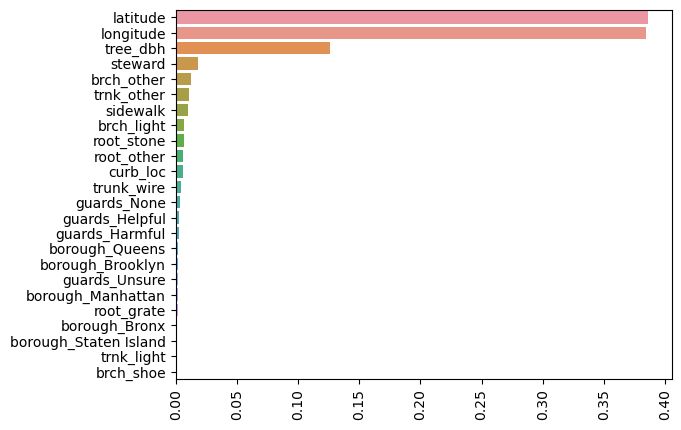

In [121]:
feat_importance(x_dev.columns, accuracy_over_rfc)

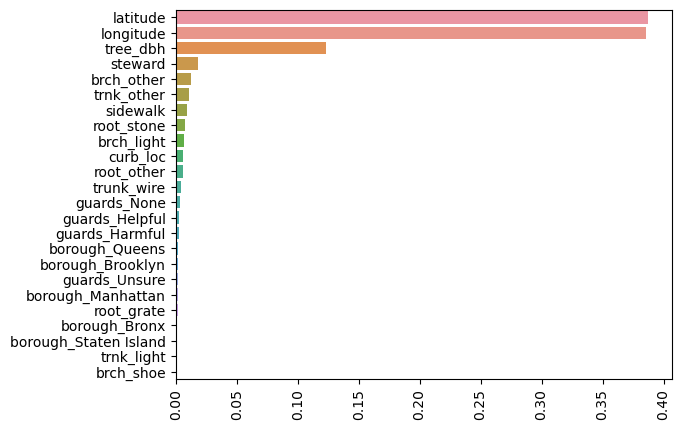

In [122]:
feat_importance(x_dev.columns, f1_over_rfc)

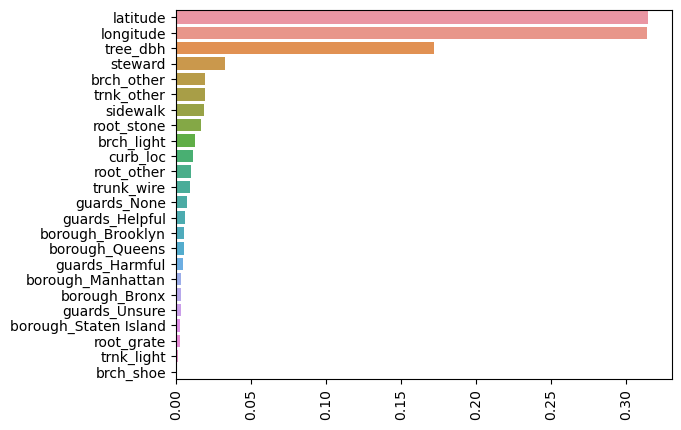

In [125]:
feat_importance(x_dev.columns, accuracy_under_rfc)

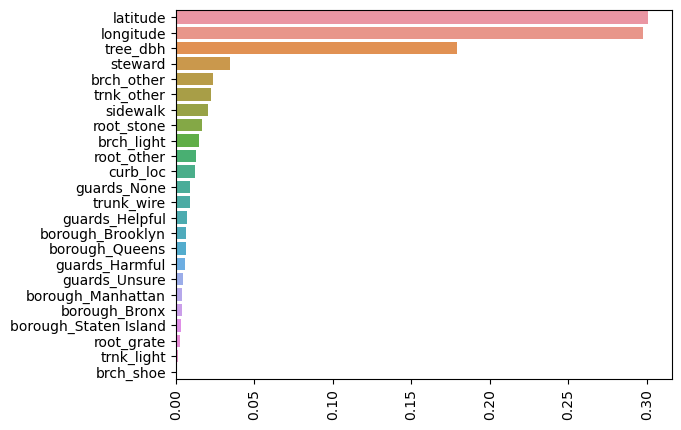

In [126]:
feat_importance(x_dev.columns, f1_under_rfc)

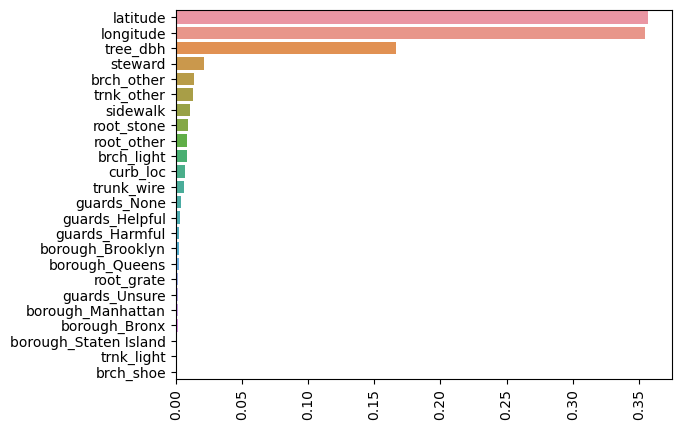

In [127]:
feat_importance(x_dev.columns, accuracy_smote_rfc)

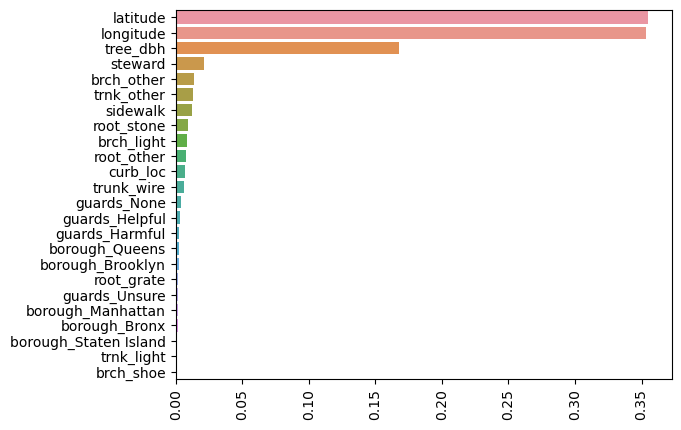

In [128]:
feat_importance(x_dev.columns, f1_smote_rfc)

In [142]:
def conf_matrix_and_f1(rfc):
    plot_confusion_matrix(rfc, x_test, y_test)
    plt.show()
    
    print("f1 score weighted: ", f1_score(y_test, rfc.predict(x_test), average='weighted'))
    print("f1 score macro: ", f1_score(y_test, rfc.predict(x_test), average='macro'))
    print("f1 score micro: ", f1_score(y_test, rfc.predict(x_test), average='micro'))

/Users/talzuss/anaconda3/envs/aml/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


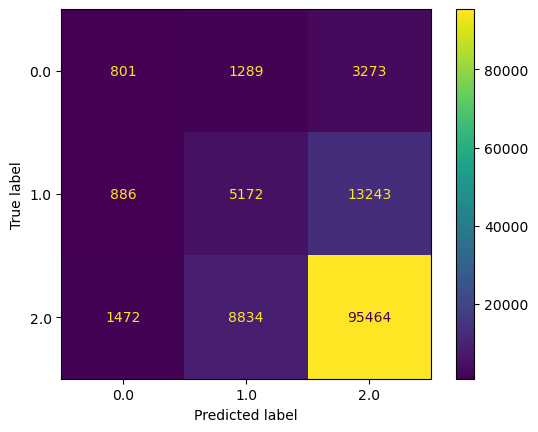

f1 score weighted:  0.7629951635086877
f1 score macro:  0.4546000627658075
f1 score micro:  0.7776883327966635


In [143]:
conf_matrix_and_f1(accuracy_over_rfc)

/Users/talzuss/anaconda3/envs/aml/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


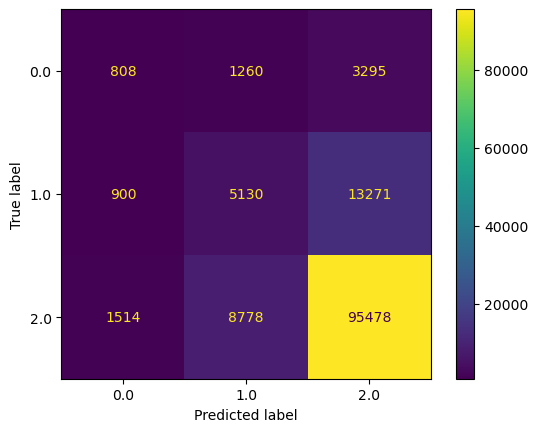

f1 score weighted:  0.762703220878496
f1 score macro:  0.4541956727257576
f1 score micro:  0.7775273318306577


In [144]:
conf_matrix_and_f1(f1_over_rfc)

/Users/talzuss/anaconda3/envs/aml/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


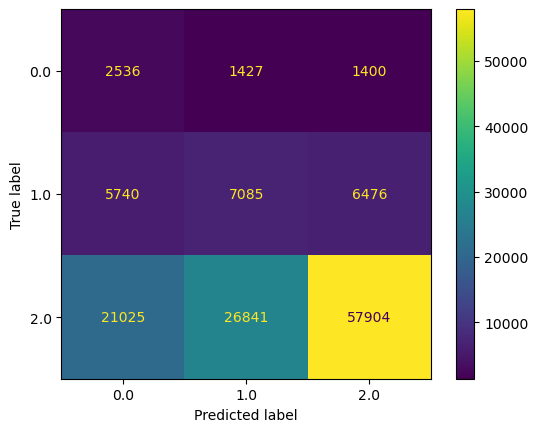

f1 score weighted:  0.5917998601178943
f1 score macro:  0.36021827732894524
f1 score micro:  0.5176947728353036


In [145]:
conf_matrix_and_f1(accuracy_under_rfc)

/Users/talzuss/anaconda3/envs/aml/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


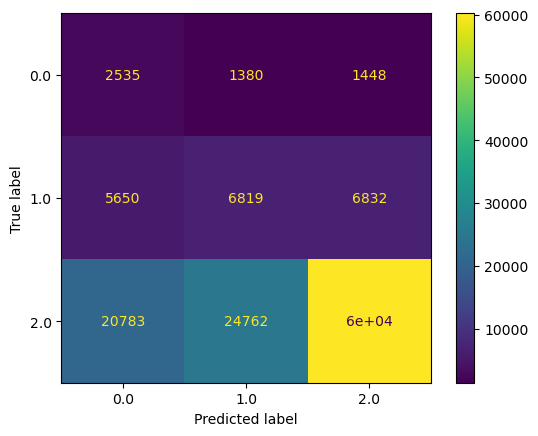

f1 score weighted:  0.6051453103764101
f1 score macro:  0.3665944691374035
f1 score micro:  0.5334422006532039


In [146]:
conf_matrix_and_f1(f1_under_rfc)

/Users/talzuss/anaconda3/envs/aml/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


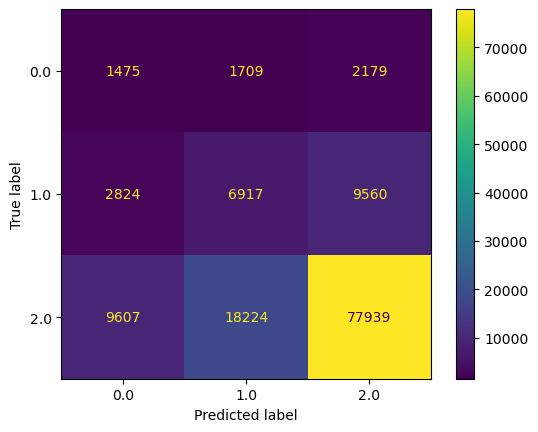

f1 score weighted:  0.6973844973054956
f1 score macro:  0.41679761821536654
f1 score micro:  0.6618749712498275


In [147]:
conf_matrix_and_f1(accuracy_smote_rfc)

/Users/talzuss/anaconda3/envs/aml/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


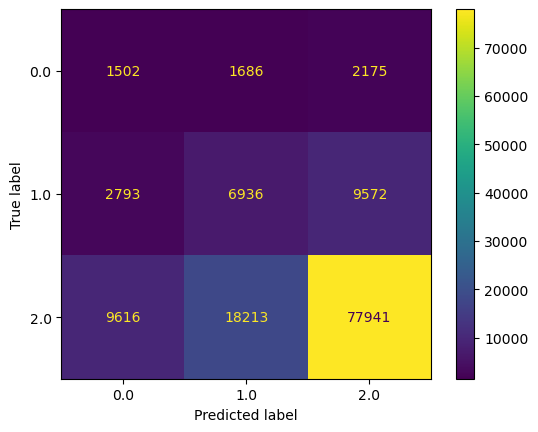

f1 score weighted:  0.6976178691126276
f1 score macro:  0.41801853725057886
f1 score micro:  0.6622429734578408


In [148]:
conf_matrix_and_f1(f1_smote_rfc)

/Users/talzuss/anaconda3/envs/aml/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


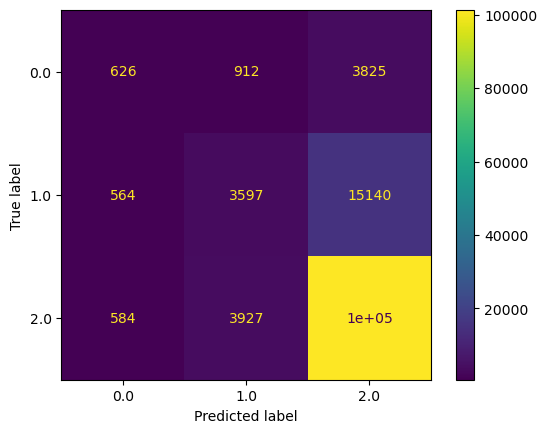

f1 score weighted:  0.7722643607907234
f1 score macro:  0.4436365769878708
f1 score micro:  0.8087001855344466


In [150]:
conf_matrix_and_f1(rfc_non_sample)